# Chapter 9: Ordinary differential equations

Robert Johansson

Updated source code listings for Numerical Python - A Practical Techniques Approach for Industry (ISBN 978-1-484205-54-9).

Updator: Kee-Youn Yoo

In this chapter we will explore both symbolic and numerical approaches to solving ODE problems.
For symbolic methods we use the Sympy module, and for numerical integration of ODEs we use functions
from the `integrate` module in Scipy.

## Importing modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

import numpy as np
from scipy import integrate
import sympy
sympy.init_printing()

## Ordinary differential equations

The simplest form of an ordinary differential equation is

$$ \frac{dy(x)}{dx} = f(x,y(x))$$,

where $y(x)$ is the unknown function and $f(x, y (x))$ is known. Only the first derivative occurs in the equation, and it is therefore an example of a first-order ODE. More generally, we can write an ODE of $n$-th order in *explicit form* as

$$ \frac{d^ny}{dx^n} = f\left(x,y,\frac{dy}{dx},\cdots,\frac{d^{n-1}y}{dx^{n-1}}\right)$$,

or in *implicit form* as

$$ F\left(x,y,\frac{dy}{dx},\cdots,\frac{d^{n}y}{dx^{n}}\right)=0$$,

where $f$ and $F$ are known functions. The general solution of an $n$-th order ODE have $n$ free parameters
that we need to specify, for example, as initial conditions for the unknown function and $n -1$ of its derivatives.

An ODE can always be rewritten as a system of first-order ODEs. Specifically, the $n$-th order ODE on the
explicit form can be written in the standard form by introducing $n$ new functions

$$y_1 = y,\, y_2=\frac{dy}{dx},\, \cdots,\, y_n = \frac{dy^{n-1}}{dx^{n-1}}.$$

This gives the following system of first-order ODEs:

$$ \frac{d}{dx}
\begin{bmatrix}
y_1\\ 
y_2\\ 
\vdots\\ 
y_{n-1}\\ 
y_n
\end{bmatrix}
=
\begin{bmatrix}
y_2\\ 
y_1\\ 
\vdots\\ 
y_n\\ 
f(x,y_1,\cdots, y_n)
\end{bmatrix}
,$$

which also can be written in a more compact vector form:

$$\frac{d\mathbf{y}}{dx} = \mathbf{f}(x,\mathbf{y}(x)).$$

This canonical form is particularly useful for numerical solutions of ODEs, and it is common that numerical methods for solving
ODEs takes the function $\mathbf{f} = (f_1, f_2,\cdots,f_n)$.

If the functions $f_1, f_2, \cdots, f_n$ are all linear, then the corresponding system of ODEs can be written on the
simple form

$$ \frac{d\mathbf{y}}{dx} = \mathbf{A}(\mathbf{x})\mathbf{y}(\mathbf{x}) +\mathbf{r}(\mathbf{x}),$$

where $\mathbf{A}(\mathbf{x})$ is an $n\times n$ matrix, and $\mathbf{r}(\mathbf{x})$ is an $n$-vector, that only depend
on $\mathbf{x}$. In this form, the $\mathbf{r}(\mathbf{x})$ is known as the source term, and the linear system is known as homogeneous if
$\mathbf{r}(\mathbf{x})=\mathbf{0}$, and nonhomogeneous otherwise.

For certain properties and forms of the function $\mathbf{f}(\mathbf{x}, \mathbf{y}(\mathbf{x}))$, there may be known solutions and special methods for solving the corresponding ODE problem, but there is no general method for an arbitrary $\mathbf{f}(\mathbf{x}, \mathbf{y}(\mathbf{x}))$, x)), other than approximate numerical methods. In addition to the properties of $\mathbf{f}(\mathbf{x}, \mathbf{y}(\mathbf{x}))$, the boundary conditions for an ODE also influence the solvability of the ODE problem, as well as which numerical approaches are available. There are two main types of boundary conditions for ODE problems: initial value conditions
and boundary value conditions.

## Symbolic solution to ODEs

Sympy provides a generic ODE solver `sympy.dsolve`, which is able to find analytical solutions to many
elementary ODEs. The `sympy.dsolve` function attempts to automatically classify a given ODE, and it may
attempt a variety of techniques to find its solution. While `dsolve` can be used to solve many simple
ODEs symbolically, as we will see in the following, it is worth keeping in mind that most ODEs cannot be
solved analytically. Typical examples of ODEs where one can hope to find a symbolic solution are ODEs
of first or second-order, or linear systems of first-order ODEs with only a few unknown functions.

The first example is the simple first-order ODE for Newton's
cooling law, $\frac{dT(t)}{dt} = -k(T(t) -T_a)$, with the initial value $T(0) = T_0$.

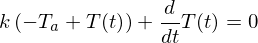

In [2]:
t, k, T0, Ta = sympy.symbols("t, k, T_0, T_a")
T = sympy.Function("T")

ode = T(t).diff(t) + k*(T(t) - Ta)
sympy.Eq(ode) # display the equation including the equality sign and a right-hand side that is zero.

In [3]:
ode_sol = sympy.dsolve(ode); ode_sol

The return value from the `sympy.dsolve` is an instance of `sympy.Eq`Eq, which is a symbolic
representation of an equality.

In [4]:
ode_sol.lhs, ode_sol.rhs

Once the general solution has been found, we need to use the initial conditions to find the values of the
yet-to-be-determined integration constants. we first
create a dictionary that describes the initial condition, `ics = {T(0): T0}`, which we can use with Sympy's
`subs` method to apply the initial condition to the solution of the ODE. This results in an equation for the
unknown integration constant $C_1$:

In [5]:
ics = {T(0): T0}
C_eq = sympy.Eq(ode_sol.lhs.subs(t, 0).subs(ics), ode_sol.rhs.subs(t, 0)); C_eq

In the present example, the equation for $C_1$ is trivial to solve, but for the sake of generality, here we
solve it using sympy.solve. The result is a list of solutions:

In [6]:
C_sol = sympy.solve(C_eq); C_sol

In [7]:
ode_sol.subs(C_sol[0])

Applying the initial conditions and solving for the undetermined integration constants can be slightly tedious, and it
worthwhile to collect these steps in a reusable function. The following function `apply_ics` is a basic
implementation that generalizes these steps to a differential equation of arbitrary order.

In [8]:
def apply_ics(sol, ics, x, known_params):
    """
    Apply the initial conditions (ics), given as a dictionary on
    the form ics = {y(0): y0: y(x).diff(x).subs(x, 0): y1, ...}
    to the solution of the ODE with indepdendent variable x.
    The undetermined integration constants C1, C2, ... are extracted
    from the free symbols of the ODE solution, excluding symbols in
    the known_params list.
    """
    free_params = sol.free_symbols - set(known_params)
    eqs = [(sol.lhs.diff(x, n) - sol.rhs.diff(x, n)).subs(x, 0).subs(ics)
           for n in range(len(ics))]
    sol_params = sympy.solve(eqs, free_params)
    
    return sol.subs(sol_params)

In [9]:
T_sol = apply_ics(ode_sol, ics, t, [k, Ta]); T_sol

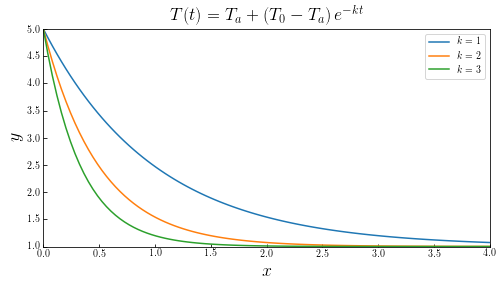

In [10]:
x = np.linspace(0, 4, 100)
y = sympy.lambdify((t, k),T_sol.rhs.subs({T0: 5, Ta: 1}), 'numpy')

fig, ax = plt.subplots(figsize=(8, 4))

for k in [1, 2, 3]:
    ax.plot(x, y(x, k), label=r"$k=%d$" % k)

ax.set_title(r"$%s$" % sympy.latex(T_sol), fontsize=18)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$y$", fontsize=18)
ax.legend()
ax.set_xlim(0, 4)
ax.set_ylim(1, 5)
ax.tick_params(which='both', direction='in')

As an example of a slightly
more complicated problem, consider the ODE for a damped harmonic oscillator, which is a second-order
ODE on the form

$$ \frac{d^2x(t)}{dt^2} +2\gamma \omega_0 \frac{dx(t)}{dt} +\omega_0^2 x(t) = 0$$

where $x(t)$ is the position of the oscillator at time $t$, $\omega_0$ is
the frequency for the undamped case, and $\gamma$ is the damping ratio.

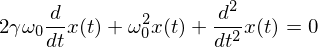

In [11]:
t, omega0, gamma = sympy.symbols("t, omega_0, gamma", positive=True)
x = sympy.Function("x")

ode = x(t).diff(t, 2) + 2*gamma*omega0 * x(t).diff(t) + omega0**2 * x(t)
sympy.Eq(ode)

In [12]:
ode_sol = sympy.dsolve(ode); ode_sol

Since this is a second-order ODE, there are two undetermined integration constants in the general
solution. We need to specify initial conditions for both the position $x(0)$ and the velocity
$ \frac{dx(t)}{dt}$ to single out a particular solution to the ODE.

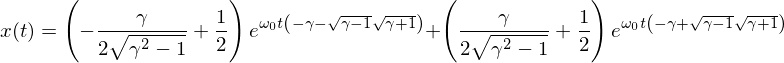

In [13]:
ics = {x(0): 1, x(t).diff(t).subs(t, 0): 0}
x_sol = apply_ics(ode_sol, ics, t, [omega0, gamma]); x_sol

This is the solution for the dynamics of the oscillator for arbitrary values of $t$, $\omega_0$ and $\gamma$. However, substituting $\gamma = 1$, which corresponds to critical damping, directly into this expression results in a division by zero error, and for this particular choice of $\gamma$ we need to careful and compute the limit where $\gamma \rightarrow 1$.

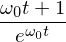

In [14]:
x_critical = sympy.limit(x_sol.rhs, gamma, 1); x_critical

Finally, we plot the solutions for $\omega_0 = 2\pi$ and a sequence of different values of the damping ratio $\gamma$ :

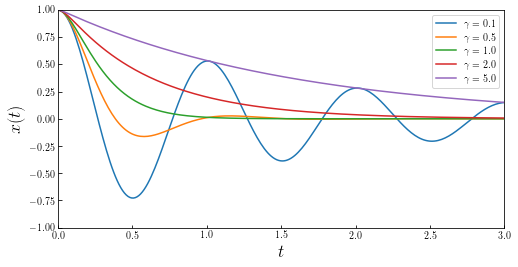

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))

tt = np.linspace(0, 3, 250)
for g in [0.1, 0.5, 1, 2.0, 5.0]:
    if g == 1:
        x_t = sympy.lambdify(t, x_critical.subs({omega0: 2.0 * sympy.pi}), 'numpy')
    else:
        x_t = sympy.lambdify(t, x_sol.rhs.subs({omega0: 2.0 * sympy.pi, gamma: g}), 'numpy')
    ax.plot(tt, x_t(tt).real, label=r"$\gamma = %.1f$" % g)

ax.set_xlabel(r"$t$", fontsize=18)
ax.set_ylabel(r"$x(t)$", fontsize=18)
ax.legend()
ax.set_xlim(0, 3)
ax.set_ylim(-1, 1,5)
ax.tick_params(which='both', direction='in')

Even many first-order ODEs cannot be solved exactly in terms of
elementary functions. For example, consider $\frac{dy}{dx} = x +y^2$, which is an example of an ODE that does
not have any closed-form solution.

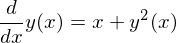

In [16]:
x = sympy.symbols("x")
y = sympy.Function("y")
f = y(x)**2 + x
sympy.Eq(y(x).diff(x), f)

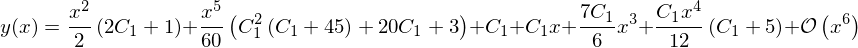

In [17]:
sympy.dsolve(y(x).diff(x) - f)

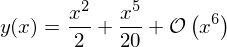

In [18]:
ics = {y(0): 0}
ode_sol = sympy.dsolve(y(x).diff(x) - f, ics=ics); ode_sol

For many other types of equations, Sympy outright fails to produce any solution at all. For example,
if we attempt to solve the second-order $\frac{d^2y}{dx} =x +y^2$

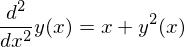

In [19]:
sympy.Eq(y(x).diff(x, 2), f)

In [20]:
sympy.dsolve(y(x).diff(x, 2) - f)

NotImplementedError: solve: Cannot solve -x - y(x)**2 + Derivative(y(x), x, x)

### Direction fields

A direction field graph is a simple but useful technique to visualize possible solutions to arbitrary first-order
ODEs. It is made up of short lines that show the slope of the unknown function on a grid in the $x–y$ plane.
This graph can be easily produced because the slope of $y(x)$ at arbitrary points of the $x–y$ plane is given by
the definition of the ODE: $\frac{dy}{dx}=f(x,y(x))$. The reason why the
direction field graph is useful is that smooth and continuous curves that tangent the slope lines (at every
point) in the direction field graph are possible solutions to the ODE.

In [21]:
def plot_direction_field(x, y_x, f_xy, x_lim=(-5, 5), y_lim=(-5, 5), ax=None):
    
    f_np = sympy.lambdify((x, y_x), f_xy, 'numpy')
    
    x_vec = np.linspace(x_lim[0], x_lim[1], 20)
    y_vec = np.linspace(y_lim[0], y_lim[1], 20)
    
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 4))

    dx = x_vec[1] - x_vec[0]
    dy = y_vec[1] - y_vec[0]

    for m, xx in enumerate(x_vec):
        for n, yy in enumerate(y_vec):
            Dy = f_np(xx, yy) * dx
            Dx = 0.8 * dx**2 / np.sqrt(dx**2 + Dy**2)
            Dy = 0.8 * Dy*dy / np.sqrt(dx**2 + Dy**2)
            ax.plot([xx - Dx/2, xx + Dx/2],
                    [yy - Dy/2, yy + Dy/2], 'b', lw=0.5)
    #ax.axis('tight')
    ax.set_xlim(x_lim[0], x_lim[1])
    ax.set_ylim(y_lim[0], y_lim[1])
    ax.tick_params(which='both', direction='in')
    ax.set_title(r"$%s$" %
                 (sympy.latex(sympy.Eq(y(x).diff(x), f_xy))),
                 fontsize=18)
    
    return ax

With this function we can produce the direction field graphs for the ODEs. The direction lines in the graphs suggest how the curves that are solutions to the corresponding ODE behave, and direction field graphs are therefore a useful and tool for visualizing
solutions to ODEs that cannot be solved analytically.

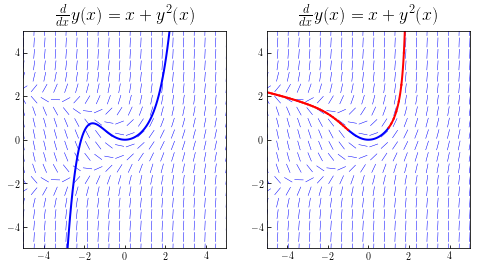

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# left panel
plot_direction_field(x, y(x), f, ax=axes[0])
x_vec = np.linspace(-3, 3, 100)
axes[0].plot(x_vec, sympy.lambdify(x, ode_sol.rhs.removeO())(x_vec), 'b', lw=2)
axes[0].set_ylim(-5, 5)

# right panel
plot_direction_field(x, y(x), f, ax=axes[1])
x_vec = np.linspace(-1, 1, 100)
axes[1].plot(x_vec, sympy.lambdify(x, ode_sol.rhs.removeO())(x_vec), 'b', lw=2)

# iteratively resolve the ODE with updated initial conditions
ode_sol_p = ode_sol_m = ode_sol
dx = 0.125

# positive x
for x0 in np.arange(1, 2., dx):
    x_vec = np.linspace(x0, x0 + dx, 100)
    ics = {y(x0): ode_sol_p.rhs.removeO().subs(x, x0)}
    ode_sol_p = sympy.dsolve(y(x).diff(x) - f, ics=ics, n=6)
    axes[1].plot(x_vec, sympy.lambdify(x, ode_sol_p.rhs.removeO())(x_vec), 'r', lw=2)

# negative x
for x0 in np.arange(1, 5, dx):
    x_vec = np.linspace(-x0-dx, -x0, 100)
    ics = {y(-x0): ode_sol_m.rhs.removeO().subs(x, -x0)}
    ode_sol_m = sympy.dsolve(y(x).diff(x) - f, ics=ics, n=6)
    axes[1].plot(x_vec, sympy.lambdify(x, ode_sol_m.rhs.removeO())(x_vec), 'r', lw=2)
    

In the left panel, we see that the approximate solution curve aligns well with the direction
field lines near $x = 0$, but starts to deviate for $|x| \geqslant 1$, suggesting that the approximate solution is no longer
valid. The solution curve shown in the right panel aligns better with the direction field throughout the plotted
range. The blue curve segment is the original approximate solution, and the red curves are continuations
obtained from resolving the ODE with an initial condition sequence that starts where the blue curves end.

The following code generates the direction field graphs for $f(x,y(x))=y^2(x) +x$, $f(x,y(x))=-x/y(x)$, and $f(x,y(x))=y^2(x)/x$

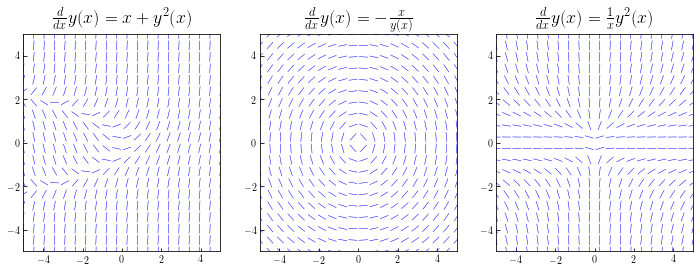

In [23]:
x = sympy.symbols("x")
y = sympy.Function("y")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

plot_direction_field(x, y(x), y(x)**2 + x, ax=axes[0])
plot_direction_field(x, y(x), -x / y(x), ax=axes[1])
plot_direction_field(x, y(x), y(x)**2 / x, ax=axes[2]);

### Solving ODEs using Laplace Transformations

A technique that can be used to solve certain ODE problems is to Laplace transform the ODE, which for many problems results in an
algebraic equation that is easier to solve. The solution to the algebraic equation can then be transformed
back to the original domain with an inverse Laplace transform, to obtain the solution to the original
problem. For example, consider the following differential equation for a driven harmonic oscillator:

$$ \frac{d^2 y}{dt^2} +2\frac{dy}{dt} +10y =2\sin 3t$$.

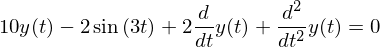

In [24]:
t = sympy.symbols("t", positive=True)
y = sympy.Function("y")

ode = y(t).diff(t, 2) + 2 * y(t).diff(t) + 10 * y(t) - 2 * sympy.sin(3*t); sympy.Eq(ode)

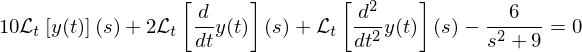

In [25]:
s, Y = sympy.symbols("s, Y", real=True)

L_ode_1 = sympy.laplace_transform(ode, t, s, noconds=True); sympy.Eq(L_ode_1)

Applying `sympy.laplace_transform` on a derivative of $y(t)$, such as $\frac{d}{dt}y(t)$, results in the unevaluated expression, 
$\mathcal{L}_t \left[ \frac{d}{dt} y(t) \right] (s)$. This is not the desired result, and we need to work
around this issue to obtain the sought-after algebraic equation. The Laplace transformation if the derivative
of an unknown function has a well-known form that involves the Laplace transform of the function itself,
rather than its derivatives. For the $n$-th derivative of a function $y(t)$, the formula is

$$\mathcal{L}_t \left[ \frac{d^n}{dt^n} y(t) \right] (s) = s^n \mathcal{L}_t \left[ y(t) \right](s) - \sum_{m=0}^{n-1} s^{n-m-1} \left. \frac{d^m}{dt^m} y(t) \right|_{t=0}$$


In [26]:
def laplace_transform_derivatives(e):
    """
    Evaluate the unevaluted laplace transforms of derivatives
    of functions
    """
    if isinstance(e, sympy.LaplaceTransform):
        if isinstance(e.args[0], sympy.Derivative):
            d, t, s = e.args
            n = len(d.args) - 1
            return ((s**n) * sympy.LaplaceTransform(d.args[0], t, s) - 
                    sum([s**(n-i) * sympy.diff(d.args[0], t, i-1).subs(t, 0)
                         for i in range(1, n+1)]))
        
    if isinstance(e, (sympy.Add, sympy.Mul)):
        t = type(e)
        return t(*[laplace_transform_derivatives(arg) for arg in e.args])
    
    return e

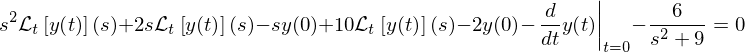

In [27]:
L_ode_2 = laplace_transform_derivatives(L_ode_1); sympy.Eq(L_ode_2)

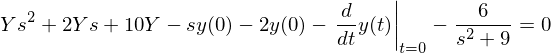

In [28]:
L_y = sympy.laplace_transform(y(t), t, s)
L_ode_3 = L_ode_2.subs(L_y, Y); sympy.Eq(L_ode_3)

At this point we need to specify the boundary conditions for the ODE problem. Here we use $y(0) = 1$
and $y'(t) = 0$, and after creating dictionary that contains these boundary conditions, we use it to substitute
the values into the Laplace-transformed ODE equation:

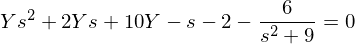

In [29]:
ics = {y(0): 1, y(t).diff(t).subs(t, 0): 0}
L_ode_4 = L_ode_3.subs(ics); sympy.Eq(L_ode_4)

This is an algebraic equation that can be solved for $Y$:

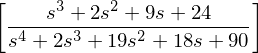

In [30]:
Y_sol = sympy.solve(L_ode_4, Y); Y_sol

The result is a list of solutions, which in this case contains only one element. Performing the inverse
Laplace transformation on this expression gives the solution to the original problem in the time domain:

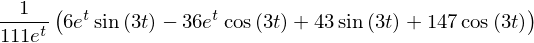

In [31]:
y_sol = sympy.inverse_laplace_transform(Y_sol[0], s, t); sympy.simplify(y_sol)

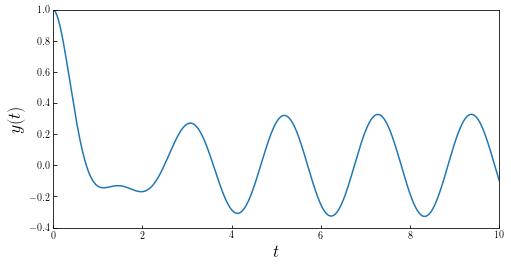

In [32]:
fig, ax = plt.subplots(figsize=(8, 4))

tt = np.linspace(0, 10, 500)
y_t = sympy.lambdify(t, y_sol, 'numpy')

ax.plot(tt, y_t(tt).real)
ax.set_xlabel(r"$t$", fontsize=18)
ax.set_ylabel(r"$y(t)$", fontsize=18)
ax.set_xlim(0, 10)
ax.set_ylim(-0.4, 1)
ax.tick_params(which='both', direction='in')

## Numerical methods for solving ODEs

In practice, ODE problems are therefore mainly solved with numerical methods. There are many approaches to
solving ODEs numerically, and most of them are designed for problems that are formulated as a system of
first-order ODEs on the standard form:

$$ \frac{d\mathbf{y}}{dx} = \mathbf{f}(x, \mathbf{y}(x)).$$

The basic idea of many numerical methods for ODEs is captured in Euler's method. This method can,
for example, be derived from a Taylor-series expansion of $y(x)$ around the point $x$:

$$ y(x+h) = y(x) +\frac{dy(x)}{dx}h +\frac{d^2 y(x)}{dx^2} h^2 + \cdots, $$

where for notational simplicity we consider the case when y(x) is a scalar function.
By dropping terms of second order or higher we get the approximate equation

$$ y(x+h) \approx y(x) +\frac{dy(x)}{dx}h, $$

which is accurate to first order in the stepsize $h$. This equation can be turned into an iteration formula by discretizing the
$x$ variable, $x_0$, $x_1$, $\cdots$, $x_k$, choosing the stepsize $h_k =x_{k+1} -x_{k}$, and denoting $y_k = y(x_k)$.
The resulting iteration formula: 

$$y_{k+1} \approx y_{k} +f(x_k, y_k) h_k,$$ 

is known as the *forward Euler method*, 
and it is said to be an *explicit form* because given the value of the $y_k$ we can directly compute $y_{k+1}$ using the formula.
There are two types of errors involved in this approach: First, the truncation of
the Taylor series gives error that limits the accuracy of the method. Second, using the approximation of $y_k$
given by the previous iteration when computing $y_{k+1}$ gives an additional error that may accumulate over
successive iterations, and that can affect the *stability* of the method.

An alternative form, which can be derived in a similar manner, is the *backward Euler method*, given by
the iteration formula

$$y_{k+1} \approx y_{k} +f(x_{k+1}, y_{k+1}) h_k.$$

This is an example of a backward differentiation formula(BDF), which is *implicit*, because $y_{k+1}$ occurs 
on both sides of the equation. To compute $y_{k+1}$ we therefore
need to solve an algebraic equation (for example using Newton’s method).
Implicit methods are more complicated to implement than explicit methods, and each iteration requires more computational
work. However, the advantage is that implicit methods generally have *larger stability region* and *better
accuracy*, which means that larger stepsize $h_k$ can be used while still obtaining an accurate and stable
solution. Implicit methods are often particularly useful for stiff problems, which loosely speaking are
ODE problems that describe dynamics with multiple disparate time scales.

There are several methods to improve upon the first-order Euler forward and backward methods.
One strategy is to keep higher-order terms in the Taylor-series expansion of $y(x + h)$. 
However, such methods require evaluating higher-order derivatives
of $y(x)$, which may be a problem. Ways around this problem include to approximate the higher-order derivatives using finite-difference
approximations of the derivatives, or by sampling the function $f(x, y(x))$ at intermediary points in the interval
$[x_k, x_{k+1}]$. An example of this type of method is the well-known *Runge-Kutta method*, which is a single-step
method that uses additional evaluations of $f(x, y(x))$. The most well-known Runge-Kutta method is the
4th-order scheme:

$$ y_{k+1} = y_k +\frac{h_k}{6} (k_1 +2k_2 +2k_3 +k_4), $$

where

$$
\begin{align*}
 k_1 &= f(t_k, \,y_k),\\ 
 k_2 &= f\left(t_k + \frac{h_k}{2},\, y_k +h_k \frac{k_1}{2} \right),\\ 
 k_3 &= f\left(t_k + \frac{h_k}{2},\, y_k +h_k \frac{k_2}{2} \right),\\ 
 k_4 &= f(t_k +h_k, \,y_k +h_k k_3).
\end{align*}
$$

Here, $k_1$ to $k_4$ are four different evaluations of the ODE function $f(x, y(x))$ that are used in the explicit
formula for $y_{k+1}$ given above. The resulting estimate of $y_{k+1}$ is accurate to 4-th order, with an error of 5-th order.

Higher-order schemes that use more function evaluations can also be constructed. By combining two
methods of different order, it can be possible to also estimate the error in the approximation. A popular
combination is the Runge-Kutta 4-th and 5-th order schemes, which results in a 4-th order accurate method
with error estimates. It is known as *RK45* or the *Runge-Kutta-Fehlberg method*. The *Dormand-Prince
method* is another example of a higher-order method, which additionally uses adaptive stepsize control. For
example, the 8-5-3 method combines 3rd and 5-th order schemes to produce an 8-th order method.

An alternative method is to use more than one previous value of $y_k$ to compute $y_{k+1}$. Such methods are
known as *multistep methods*, and can in general be written on the form

$$ y_{k + s} = \sum_{n=0}^{s-1} a_n y_{k + n} + h \sum_{n=0}^{s} b_n f(x_{k + n}, y_{k + n}).$$

This formula means that to compute $y_{k+s}$, the previous $s$ values of $y_k$ and $f(x_k, y_k)$ are used (known as an
s-step method). The choices of the coefficients $a_n$ and $b_n$ give rise to different multistep methods. Note that if
$b_s = 0$, then the method is explicit, and if $b_s \neq 0$ it is implicit.

For example, $b_0 = b_1 = \cdots = b_{s-1} = 0$ gives the general formula for an s-step BDF formula. where $a_n$ and $b_n$
are chosen to maximize the order of the accuracy. For example, the one-step BDF method with $b_1 = a_0 = 1$ reduces to the
backward Euler method, and the two-step BDF method, 

$$y_{k+2} = a_0 y_k +a_1 y_{k+1} +hb_2 f(x_{k+2}, y_{k+2}),$$

when solved for the coefficients $(a_0, a_1, b_2)$ becomes $(-\frac{1}{3},\,\frac{4}{3},\,\frac{2}{3})$.

Another family of multistep methods are the Adams methods, which result from the choice $a_0 = a_1 = \cdots = a_{s-2} = 0$, and
$a_{s-1}=1$, where again the remaining unknown coefficients are chosen to maximize
the order of the method. Specifically, the explicit method with $b_s = 0$ are known as Adams-Bashforth
methods, and the implicit methods with $b_s \neq 0$ are known as Adams-Moulton methods. For example, the
one-step Adams-Bashforth and Adams-Moulton methods reduce to the forward and backward Euler
methods, respectively, and the two-step methods are

$$y_{k+2} = y_{k+1} + h \left( -\frac{1}{2} f(x_{k}, y_{k}) + \frac{3}{2} f(x_{k+1}, y_{k+1}) \right),$$

and

$$y_{k+1} = y_{k} + \frac{h}{2} \left( f(x_{k}, y_{k}) + f(x_{k+1}, y_{k+1}) \right),$$

respectively.

In general explicit methods are more convenient to implement and less computationally demanding to
iterate than implicit methods, which in principle requires solving (a potentially nonlinear) equation in each
iteration with an initial guess for the unknown $y_{k+1}$. However, as mentioned earlier, implicit methods often
are more accurate and have superior stability properties. A compromise that retain some of the advantages
of both methods is to combine explicit and implicit methods in the following way:
First compute $y_{k+1}$ using
an explicit method, then use this $y_{k+1}$ as an initial guess for solving the equation for $y_{k+1}$ given by an implicit
method. This equation does not need to be solved exactly, and since the initial guess from the explicit
method should be quite good, a fixed number of iterations, using for example Newton's method, could be
sufficient. Methods like these, where an explicit method is used to predict $y_{k+1}$ and an
implicit method is used to correct the prediction, are called *predictor-corrector methods*.

## Numerical integration of ODEs using scipy

The integrate module of Scipy
provides two ODE solver interfaces: `integrate.odeint` and `integrate.ode`. The `odeint` function is an
interface to the LSODA solver from ODEPACK, which automatically switches between an Adams predictor-corrector
method for non-stiff problems and a BDF method for stiff problems.
In contrast, the `integrate.ode`
class provides an object-oriented interface to number of different solvers: the VODE and ZVODE solvers
(ZVODE is a variant of VODE for complex-valued functions), the LSODA solver, and dopri5 and dop853,
which are fourth and eighth order Dormand-Prince methods (that is, types of Runge-Kutta methods) with
adaptive stepsize. While the object-oriented interface provided by `integrate.ode` is more flexible, the
`odeint` function is in many cases simpler and more convenient to use. In the following we look at both these
interfaces, starting with the `odeint` function.

For example, consider again the scalar ODE $y'(x) = f(x, y(x)) = x + y^2(x)$.

In [33]:
x = sympy.symbols("x")
y = sympy.Function("y")

f = y(x)**2 + x
f_np = sympy.lambdify((y(x), x), f)

In [34]:
y0 = 0
xp = np.linspace(0, 1.9, 100)
yp = integrate.odeint(f_np, y0, xp)
xm = np.linspace(0, -5, 100)
ym = integrate.odeint(f_np, y0, xm)

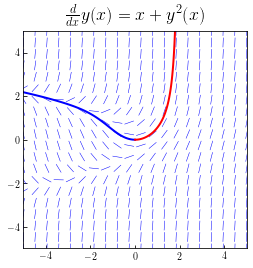

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_direction_field(x, y(x), f, ax=ax)
ax.plot(xm, ym, 'b', lw=2)
ax.plot(xp, yp, 'r', lw=2);

In the previous example we solved a scalar ODE problem. More often we are interested in vector-valued
ODE problems (systems of ODEs). To see how we can solve that kind of problems using odeint, consider the
Lokta-Volterra equations for the dynamics of a population of predator and prey animals (a classic example of
coupled ODEs). The equations are

$$
x'(t) = a x - b x y
$$

$$
y'(t) = c x y - d y
$$

where $x(t)$ is the number of prey animals and $y(t)$ is the number of predator animals, and the coefficients $a$, $b$, $c$, and $d$ describe the rates of the processes in the model.

In [36]:
a, b, c, d = 0.4, 0.002, 0.001, 0.7
def f(xy, t):
    x, y = xy
    return [a * x - b * x * y, c * x * y - d * y]

In [37]:
xy0 = [600, 400]
t = np.linspace(0, 50, 250)

xy_t = integrate.odeint(f, xy0, t); xy_t.shape

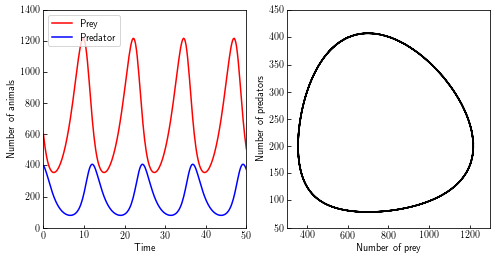

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].plot(t, xy_t[:,0], 'r', label="Prey")
axes[0].plot(t, xy_t[:,1], 'b', label="Predator")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Number of animals")
axes[0].legend()
axes[0].set_xlim(0, 50)
axes[0].set_ylim(0, 1400)
axes[0].tick_params(which='both', direction='in')

axes[1].plot(xy_t[:,0], xy_t[:,1], 'k')
axes[1].set_xlabel("Number of prey")
axes[1].set_ylabel("Number of predators")
axes[1].set_xlim(300, 1300)
axes[1].set_ylim(50, 450)
axes[1].tick_params(which='both', direction='in')

In the previous two examples, the function for the right-hand side of the ODE was implemented without
additional arguments. Rather than using global variables, it is often convenient and elegant to implement the
f function in such a way that it takes arguments for all its coefficient or parameters. To illustrate this point,
let’s consider another famous ODE problem: the Lorenz equations, which is the following system of three
coupled nonlinear ODEs,

$$
\begin{align*}
x'(t) &= \sigma(y - x)\\ 
y'(t) &= x(\rho - z) - y \\ 
z'(t) &= x y - \beta z
\end{align*}
$$


In [39]:
def f(xyz, t, rho, sigma, beta):
    x, y, z = xyz
    return [sigma * (y - x),
            x * (rho - z) - y,
            x * y - beta * z]

In [40]:
xyz0 = [1.0, 1.0, 1.0]
t = np.linspace(0, 25, 10000)

In [41]:
rho, sigma, beta = 28, 8, 8/3.0

In [42]:
xyz1 = integrate.odeint(f, xyz0, t, args=(rho, sigma, beta))
xyz2 = integrate.odeint(f, xyz0, t, args=(rho, sigma, 0.6*beta))
xyz3 = integrate.odeint(f, xyz0, t, args=(rho, 2*sigma, 0.6*beta))

In [43]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

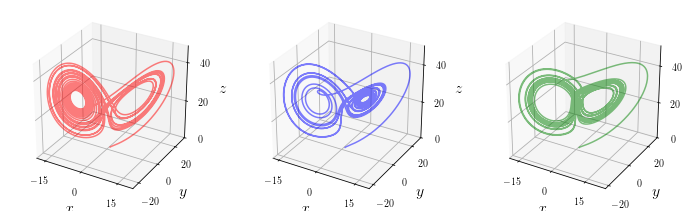

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3.5), subplot_kw={'projection': '3d'})

for ax, xyz, c in [(ax1, xyz1, 'r'), (ax2, xyz2, 'b'), (ax3, xyz3, 'g')]:
    ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], c, alpha=0.5)
    ax.set_xlabel('$x$', fontsize=16)
    ax.set_ylabel('$y$', fontsize=16)
    ax.set_zlabel('$z$', fontsize=16)
    ax.set_xticks([-15, 0, 15])
    ax.set_yticks([-20, 0, 20])
    ax.set_zticks([0, 20, 40])

While the function for $f(x, y(x))$ to be used with `odeint` had to have the function signature $f(y, x, ...)$,
the corresponding function to be used with `integrate.ode` must have the function signature $f(x, y, ...)$
(that is, the order of $x$ and $y$ is reversed). To illustrate
how to use the `integrate.ode` interface, we first look at the following sets of coupled second-order ODEs:

\begin{eqnarray}
m_1 x_1''(t) + \gamma_1 x_1'(t) + k_1 x_1(t) - k_2 (x_2(t) - x_1(t)) &=& 0\\
m_2 x_2''(t) + \gamma_2 x_2'(t) + k_2 (x_2(t) - x_1(t)) &=& 0
\end{eqnarray}

These equations describe the dynamics of two coupled springs, where $x_1(t)$ and $x_2(t)$ are the
displacement of two objects, with masses $m_1$ and $m_2$, from their equilibrium positions. The object at $x_1$ is
connect to a fixed wall via a spring with spring constant $k_1$, and connected to the object at $x_2$ via a spring with
spring constant $k_2$. Both objects are subject to damping forces characterized by $\gamma_1$ and $\gamma_2$, respectively.
To solve this kind of problem with Scipy, we first have to write it in standard form, which we can do by
introducing $y_0(t) =x_1(t)$, $y_1(t) =x_1'(t)$, $y_2(t) =x_2(t)$, and $y_3(t) =x_3'(t)$, which results in four coupled first-order
equations:

$$
\frac{d}{dt} 
\begin{bmatrix}
y_0(t)\\ 
y_1(t)\\ 
y_2(t)\\ 
y_3(t)
\end{bmatrix} =
\begin{bmatrix}
y_1(t) \\
(-\gamma_1 y_1(t) -k_1 y_0(t) -k_2 y_0(t) +k_2 y_2(t))/m_1 \\
y_3(t) \\
(-\gamma_2 y_3(t) -k_2 y_2(t) +k_2 y_0(t))/m_2 
\end{bmatrix} 
$$

In [45]:
def f(t, y, args):
    m1, k1, g1, m2, k2, g2 = args
    
    return [y[1], 
            - k1/m1 * y[0] + k2/m1 * (y[2] - y[0]) - g1/m1 * y[1], 
            y[3], 
            - k2/m2 * (y[2] - y[0]) - g2/m2 * y[3] ]

In [46]:
m1, k1, g1, m2, k2, g2 = 1.0, 10.0, 0.5, 2.0, 40.0, 0.25
args = (m1, k1, g1, m2, k2, g2)

y0 = [1.0, 0, 0.5, 0]
t = np.linspace(0, 20, 1000)

Instead of calling the `odeint` function, we now need to create an instance of the class `integrate.ode`,
passing the ODE function $f$ as an argument:

In [47]:
r = integrate.ode(f)

In [48]:
r.set_integrator('lsoda') # the possible first argument: vode, zvode, lsoda, dopri5 and dop853
r.set_initial_value(y0, t[0])
r.set_f_params(args);

In [49]:
dt = t[1] - t[0]
y = np.zeros((len(t), len(y0)))
idx = 0
while r.successful() and r.t < t[-1]:
    y[idx, :] = r.y
    r.integrate(r.t + dt)
    idx += 1

This is arguably not as convenient as simply calling the `odeint`, but it offers extra flexibility that
sometimes is exactly what is needed.

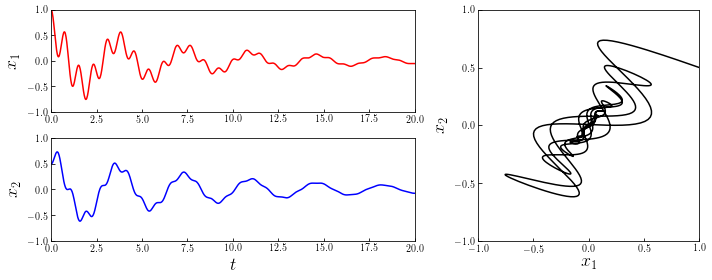

In [50]:
fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=3)
ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=2)

# x_1 vs time plot
ax1.plot(t, y[:, 0], 'r')
ax1.set_ylabel('$x_1$', fontsize=18)
ax1.set_yticks([-1, -.5, 0, .5, 1])
ax1.set_xlim(0, 20)
ax1.set_ylim(-1.0, 1.0)
ax1.tick_params(which='both', direction='in')

# x2 vs time plot
ax2.plot(t, y[:, 2], 'b')
ax2.set_xlabel('$t$', fontsize=18)
ax2.set_ylabel('$x_2$', fontsize=18)
ax2.set_yticks([-1, -.5, 0, .5, 1])
ax2.set_xlim(0, 20)
ax2.set_ylim(-1.0, 1.0)
ax2.tick_params(which='both', direction='in')

# x1 and x2 phase space plot
ax3.plot(y[:, 0], y[:, 2], 'k')
ax3.set_xlabel('$x_1$', fontsize=18)
ax3.set_ylabel('$x_2$', fontsize=18)
ax3.set_xticks([-1, -.5, 0, .5, 1])
ax3.set_yticks([-1, -.5, 0, .5, 1])

ax3.set_xlim(-1.0, 1.00)
ax3.set_ylim(-1.0, 1.0)
ax3.tick_params(which='both', direction='in')

fig.tight_layout()

Python functions for both $f(t, y(t))$ and its Jacobian can conveniently be generated using Sympy's
`lambdify`, provided that the ODE problem first can be defined as a Sympy expression. This symbolic-numeric
hybrid approach is a powerful method to solving ODE problems. To illustrate this approach,
consider the rather complicated system of two coupled second-order and nonlinear ODEs for a double
pendulum.

![double_pendulum](./figs/dimg270.gif)

$$
(m_1+m_2) l_1\theta_1'' + m_2l_2\theta_2''\cos(\theta_1-\theta_2)
+ m_2l_2(\theta_2')^2\sin(\theta_1-\theta_2)+g(m_1+m_2)\sin(\theta_1) = 0
$$

$$
m_2l_2\theta_2'' + m_2l_1\theta_1''\cos(\theta_1-\theta_2) - m_2l_1 (\theta_1')^2 \sin(\theta_1-\theta_2)
+m_2g\sin(\theta_2) = 0
$$

We begin by defining Sympy symbols for the variables and the functions in the problem, and
then construct the ode expressions:

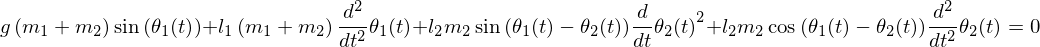

In [51]:
t, g, m1, l1, m2, l2 = sympy.symbols("t, g, m_1, l_1, m_2, l_2")
theta1, theta2 = sympy.symbols("theta_1, theta_2", cls=sympy.Function)

ode1 = sympy.Eq((m1 + m2)*l1*theta1(t).diff(t,t) +
                m2*l2*theta2(t).diff(t,t)*sympy.cos(theta1(t) -theta2(t)) +
                m2*l2*theta2(t).diff(t)**2*sympy.sin(theta1(t) - theta2(t)) + 
                g*(m1 + m2)*sympy.sin(theta1(t)))
ode1

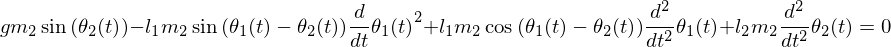

In [52]:
ode2 = sympy.Eq(m2*l2*theta2(t).diff(t,t) +
                m2*l1*theta1(t).diff(t,t)*sympy.cos(theta1(t) - theta2(t)) -
                m2*l1*theta1(t).diff(t)**2*sympy.sin(theta1(t) - theta2(t)) +
                m2*g*sympy.sin(theta2(t)))
ode2

Now `ode1` and `ode2` are Sympy expressions for the two second-order ODE equations. We first have to write the system of two second-order ODEs as a system of four first-order ODEs on standard form. To this end we need to introduce new functions $y_1(t) = \theta_1(t)$,
$y_2(t) = \theta_1'(t)$, $y_3(t) = \theta_2(t)$, $y_4(t) = \theta_2'(t)$, and rewrite the ODEs in terms of these functions.

In [53]:
y1, y2, y3, y4 = sympy.symbols("y_1, y_2, y_3, y_4", cls=sympy.Function)

varchange = {theta1(t).diff(t, t): y2(t).diff(t), 
             theta1(t): y1(t),
             theta2(t).diff(t, t): y4(t).diff(t), 
             theta2(t): y3(t)}

ode1_vc = ode1.subs(varchange)
ode2_vc = ode2.subs(varchange)
ode3 = y1(t).diff(t) - y2(t)
ode4 = y3(t).diff(t) - y4(t)

At this point we have four coupled first-order ODEs for the functions $y_1$ to $y_4$. It only remains to solve for
the derivatives of these functions to obtain the ODEs in standard form.

In [54]:
y = sympy.Matrix([y1(t), y2(t), y3(t), y4(t)])
vcsol = sympy.solve((ode1_vc, ode2_vc, ode3, ode4), y.diff(t), dict=True)
f = y.diff(t).subs(vcsol[0])

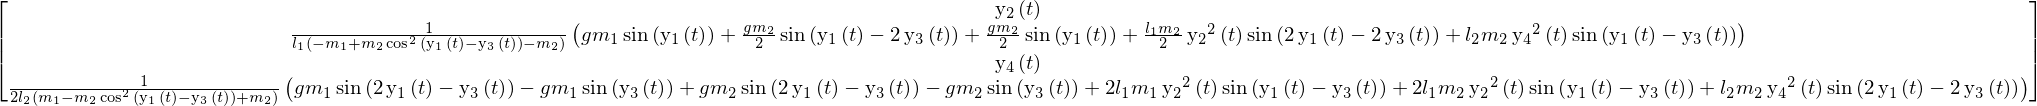

In [55]:
f

Now $f$ is Sympy expression for the ODE function $f(t, y(t))$. Also, since we have an symbolic representation of the problem so far, it is
easy to also compute the Jacobian. 

In [56]:
jac = sympy.Matrix([[fj.diff(yi) for yi in y] for fj in f])

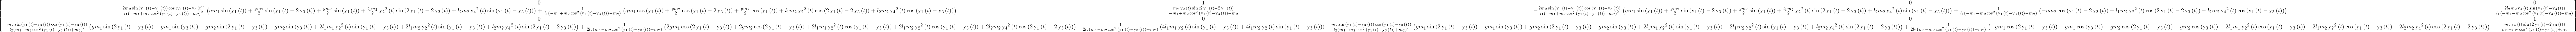

In [57]:
jac

The main purpose of constructing $f$ and it's Jacobian ere is to convert them to Numpy-aware functions that can be used with `integrate.odeint` or `integrate.ode`.

In [58]:
params = {m1: 5.0, l1: 2.0, m2: 1.0, l2: 1.0, g: 10.0}

f_np = sympy.lambdify((t, y), f.subs(params), 'numpy')
jac_np = sympy.lambdify((t, y), jac.subs(params), 'numpy')

With the functions `f_np `and `jac_np`, we are now ready to solve the ODE using integrate.ode in the same manner as in the
previous examples

In [59]:
y0 = [2.0, 0, 0.0, 0]
t = np.linspace(0, 20, 1000)
r = integrate.ode(f_np, jac_np).set_initial_value(y0, t[0])

In [60]:
dt = t[1] - t[0]
y = np.zeros((len(t), len(y0)))
idx = 0
while r.successful() and r.t < t[-1]:
    y[idx, :] = r.y
    r.integrate(r.t + dt)
    idx += 1

When visualizing this solution, it is more intuitive to plot the positions of the pendulums in the $x–y$ plane rather
than their angular deflections.

In [61]:
theta1_np, theta2_np = y[:, 0], y[:, 2]

x1 =  params[l1] * np.sin(theta1_np)
y1 = -params[l1] * np.cos(theta1_np)
x2 = x1 + params[l2] * np.sin(theta2_np)
y2 = y1 - params[l2] * np.cos(theta2_np)

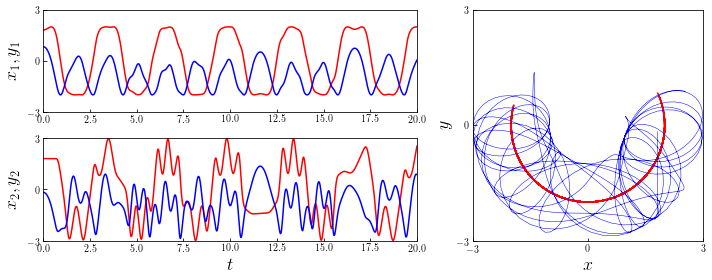

In [62]:
fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=3)
ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=2)

ax1.plot(t, x1, 'r')
ax1.plot(t, y1, 'b')
ax1.set_ylabel('$x_1, y_1$', fontsize=18)
ax1.set_yticks([-3, 0, 3])
ax1.set_xlim(0, 20)
ax1.set_ylim(-3, 3)
ax1.tick_params(which='both', direction='in')

ax2.plot(t, x2, 'r')
ax2.plot(t, y2, 'b')
ax2.set_xlabel('$t$', fontsize=18)
ax2.set_ylabel('$x_2, y_2$', fontsize=18)
ax2.set_yticks([-3, 0, 3])
ax2.set_xlim(0, 20)
ax2.set_ylim(-3, 3)
ax2.tick_params(which='both', direction='in')

ax3.plot(x1, y1, 'r')
ax3.plot(x2, y2, 'b', lw=0.5)
ax3.set_xlabel('$x$', fontsize=18)
ax3.set_ylabel('$y$', fontsize=18)
ax3.set_xticks([-3, 0, 3])
ax3.set_yticks([-3, 0, 3])
ax3.set_xlim(-3, 3)
ax3.set_ylim(-3, 3)
ax3.tick_params(which='both', direction='in')

fig.tight_layout()

## Versions

In [63]:
%reload_ext version_information
%version_information numpy, scipy, sympy, matplotlib

Software versions
Python 3.4.2 32bit [GCC 4.9.1]
IPython 6.0.0
OS Linux 4.9.24 v7+ armv7l with debian 8.0
numpy 1.8.2
scipy 0.19.0
sympy 1.0
matplotlib 2.0.0
Sat May 13 22:49:32 2017 KST